# Data import
Import sequenced data from a `json` file.

In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from pprint import pprint
import random
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-muted')

Using TensorFlow backend.


In [2]:
def get_data():
    """Returns a DataFrame with transformed data."""
    data_file = 'fightmetric/data/final.json'
    frame = pd.read_json(data_file)
    return frame
    

def get_label(event_date):
    """Helper function for choosing train and test 
    labels based on fight's date."""
    event_date = event_date.date()
    # All fights after 2015 should be 
    # associated to the test set.
    if event_date >= date(2015, 1, 1):
        return 'test'
    return 'train'


def train_test_split(data):
    """Returns train and test data."""
    data = data[(data['result'] == 'Win') | (data['result'] == 'Loss')]
    data['set'] = data['date'].apply(get_label)
    train = data.loc[data['set'] == 'train']
    test = data.loc[data['set'] == 'test']
    assert len(data) == len(train) + len(test)
    
    return train, test

def split(data):
    data = data[(data['result'] == 'Win') | (data['result'] == 'Loss')]
    y = data['result'].map({'Win': 1, 'Loss': 0})
    x = data.drop(['result'], axis=1)
    return x, y

# Data exploration

In [3]:
data = get_data()
train, test = train_test_split(data)
datasets = [train, test]

Calculating the offense accuracy averages over the training dataset.

In [4]:
keys = ['body', 'clinch', 'distance', 'ground', 'head', 
        'knockouts', 'leg', 'sig. str', 'submissions', 'td', 'total str.']

for key in keys:
    landed = train['fighter'].apply(lambda x: x['stats'][key]['landed'])
    thrown = train['fighter'].apply(lambda x: x['stats'][key]['thrown'])
    print("{}: {},".format(key, (landed.sum() / thrown.sum())))

body: 0.7473003379873279,
clinch: 0.6571087641322761,
distance: 0.3455062095114903,
ground: 0.6262766775935562,
head: 0.3628908924004376,
knockouts: 0.9343414859964508,
leg: 0.7791716658682076,
sig. str: 0.44421437047191575,
submissions: 0.2572297418162304,
td: 0.4768224733013465,
total str.: 0.5933736946615897,


Calculating the defense accuracy averages over the training dataset.

In [5]:
for key in keys:
    avoided = train['fighter'].apply(lambda x: x['stats'][key]['avoided'])
    received = train['fighter'].apply(lambda x: x['stats'][key]['received'])
    total = avoided + received
    print("{}: {},".format(key, (avoided.sum() / total.sum())))

body: 0.2876221212962016,
clinch: 0.3741905657569338,
distance: 0.6827144917612437,
ground: 0.3980045751295038,
head: 0.6875411808215335,
knockouts: 0.3100940975192472,
leg: 0.24724693306549966,
sig. str: 0.6002153958424062,
submissions: 0.8462684763784285,
td: 0.6195488480886924,
total str.: 0.4412454210775378,


# Data preparation

In [6]:
def offense_accuracy(fighter, key):
    """Calculates the accuracy 
    for a offensive statistics."""
    landed = fighter['stats'][key]['landed']
    total = fighter['stats'][key]['thrown']
    
    return landed / (total + .1)

    
def defense_accuracy(fighter, key):
    """Calculates the accuracy 
    for a defensive statistics."""
    avoided = fighter['stats'][key]['avoided']
    received = fighter['stats'][key]['received']
    total = avoided + received
    
    return avoided / (total + .1)

    
def accuracy(dataset, key):
    """Calculates the accuracy for a statistic."""
    def calc(fighter, key):
        offense = offense_accuracy(fighter, key)
        defense = defense_accuracy(fighter, key)
        return offense + defense
        
    
    fighter = dataset['fighter'].apply(lambda x: calc(x, key))
    opponent = dataset['opponent'].apply(lambda x: calc(x, key))
    return fighter - opponent


def probability(positive, both):
    """Helper funcition for calculating probabilites."""
    try:
        return positive / both
    except Exception:
        return 0.5

## Tranforming the datasets

In [7]:
for dataset in datasets:
    """
    Historical features
    """
    # Probabilities
    fighter = dataset['fighter'].apply(lambda x: probability(x['history']['wins'], x['history']['fights']))
    opponent = dataset['opponent'].apply(lambda x: probability(x['history']['wins'], x['history']['fights']))
    dataset['Win probability'] = fighter - opponent
    # Streak wins minus losses
    fighter = dataset['fighter'].apply(lambda x: x['streak']['wins'] - x['streak']['losses'])
    opponent = dataset['opponent'].apply(lambda x: x['streak']['wins'] - x['streak']['losses'])
    dataset['Streak'] = fighter - opponent
    # Time spent in the octagon
    fighter = dataset['fighter'].apply(lambda x: x['history']['time'])
    opponent = dataset['opponent'].apply(lambda x: x['history']['time'])
    dataset['Time'] = fighter - opponent
    # Avg position in the fightcard
    fighter = dataset['fighter'].apply(lambda x: x['history']['position'] / 
                                                (x['history']['fights'] + .1))
    opponent = dataset['opponent'].apply(lambda x: x['history']['position'] / 
                                                  (x['history']['fights'] + .1))
    dataset['Avg position'] = fighter - opponent
    # Is first fight
    dataset['Is first'] = dataset['fighter'].apply(lambda x: x['history']['fights'] > 0).astype(int)
    
    
    """
    Physiacal features
    """
    # Difference in age
    fighter = dataset['fighter'].apply(lambda x: x['age'])
    opponent = dataset['opponent'].apply(lambda x: x['age'])
    dataset['Age'] = fighter - opponent
    # Difference in reach
    fighter = dataset['fighter'].apply(lambda x: x['reach'])
    opponent = dataset['opponent'].apply(lambda x: x['reach'])
    dataset['Reach'] = fighter - opponent
    # Knockouts
    fighter = dataset['fighter'].apply(lambda x: x['stats']['knockouts']['landed'])
    opponent = dataset['opponent'].apply(lambda x: x['stats']['knockouts']['landed'])
    dataset['Knockouts'] = fighter - opponent
    # Submissions
    fighter = dataset['fighter'].apply(lambda x: x['stats']['submissions']['landed'])
    opponent = dataset['opponent'].apply(lambda x: x['stats']['submissions']['landed'])
    dataset['Submissions'] = fighter - opponent
    
    
    
    """
    Performance features
    """
    dataset['Striking'] = accuracy(dataset, 'sig. str')
    dataset['Takedowns'] = accuracy(dataset, 'td')

## Feature selection and scaling

In [8]:
# Removing unneccessary features from both datasets
for dataset in datasets:
    for key in ['date', 'event', 'fighter', 'link', 'opponent', 
                'location', 'method', 'referee', 'set']:
        if key in dataset:
            dataset.drop([key], axis=1, inplace=True)
            

# Imputing NaN values
train = train.replace([np.inf, -np.inf], np.nan)
xtrain, ytrain = split(train)
imputer = Imputer(strategy='median')
imputer.fit(xtrain)
xtrain = pd.DataFrame(imputer.transform(xtrain), columns=xtrain.columns)
assert len(xtrain) == len(ytrain) == len(train)

test = test.replace([np.inf, -np.inf], np.nan) 
xtest, ytest = split(test)
xtest = pd.DataFrame(imputer.transform(xtest), columns=xtest.columns)
assert len(test) == len(ytest) == len(xtest)

# Scaling the datasets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = pd.DataFrame(scaler.transform(xtrain), columns=xtrain.columns)
xtest = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns)

## Overview

In [9]:
for dataset in datasets:
    print('Dataset of {} features with {} rows.'.format(len(list(dataset.columns)),
                                                        len(dataset)))
    
xtrain.tail()

Dataset of 12 features with 9282 rows.
Dataset of 12 features with 2554 rows.


,Win probability,Streak,Time,Avg position,Is first,Age,Reach,Knockouts,Submissions,Striking,Takedowns
9277,-0.627380,-0.405441,-0.707055,-1.211207,-1.939072,-0.199270,-0.769245,-1.544806,0.000000,-1.836196,-1.349384
9278,-1.463886,0.000000,0.108441,-0.526321,0.515711,0.000000,-1.153867,-0.386201,0.000000,-0.605722,0.563001
9279,-2.927772,-1.621763,0.031608,0.282416,0.515711,0.597809,-2.692357,0.000000,-0.435536,-0.669989,-0.607997
9280,-0.292777,-0.810881,-0.727479,-2.442069,-1.939072,-0.398539,0.000000,0.000000,-0.871072,-1.604566,-0.956377
9281,-1.254760,0.000000,-0.897678,0.774565,0.515711,-0.597809,0.000000,-0.386201,0.000000,-0.387814,-1.303593


# Model selection

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)

print('LogisticRegression training {:.2f}%'.format(accuracy_score(ytrain, logreg.predict(xtrain))*100))
print('LogisticRegression testing {:.2f}%'.format(accuracy_score(ytest, logreg.predict(xtest))*100))
feats = {feature: importance for feature, importance in zip(xtrain.columns, logreg.coef_[0])}
importances = pd.DataFrame.from_dict(feats, orient='index')
importances = importances.rename(columns={0: 'Importance', 1: 'Feature'})
importances = importances.iloc[importances['Importance'].abs().argsort()].iloc[::-1]
importances.head(5)

LogisticRegression training 65.03%
LogisticRegression testing 60.45%


,Importance
Striking,0.552694
Age,-0.364651
Avg position,-0.332880
Takedowns,0.222145
Streak,0.135105


In [11]:
svc = SVC()
svc.fit(xtrain, ytrain)

print('SVC training {:.2f}%'.format(accuracy_score(ytrain, svc.predict(xtrain))*100))
print('SVC testing {:.2f}%'.format(accuracy_score(ytest, svc.predict(xtest))*100))

SVC training 67.23%
SVC testing 60.06%


In [12]:
rndf = RandomForestClassifier(min_samples_split=256, random_state=42)
rndf.fit(xtrain, ytrain)

print('RandomForestClassifier training {:.2f}%'.format(accuracy_score(ytrain, rndf.predict(xtrain))*100))
print('RandomForestClassifier testing {:.2f}%'.format(accuracy_score(ytest, rndf.predict(xtest))*100))
feats = {feature: importance for feature, importance in zip(xtrain.columns, rndf.feature_importances_)}
importances = pd.DataFrame.from_dict(feats, orient='index')
importances = importances.rename(columns={0: 'Importance', 1: 'Feature'})
importances = importances.iloc[importances['Importance'].abs().argsort()].iloc[::-1]
importances.head(5)

RandomForestClassifier training 68.34%
RandomForestClassifier testing 59.28%


,Importance
Striking,0.208584
Time,0.164636
Takedowns,0.154359
Age,0.151481
Win probability,0.102990


In [13]:
input_dim = xtrain.shape[1]
model = Sequential()
model.add(Dense(8, input_dim=input_dim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [14]:
# Training the network
batch_size = 512
verbosity = 0 # 1 to see the output at each epoch
hist = model.fit(xtrain.values, ytrain, epochs=100, batch_size=batch_size, validation_split=0.2, verbose=verbosity)

In [15]:
scores = model.evaluate(xtest.values, ytest, batch_size=batch_size, verbose=verbosity)
print('\nNeural Network testing {:.2f}%'.format(scores[1]*100))


Neural Network testing 59.36%


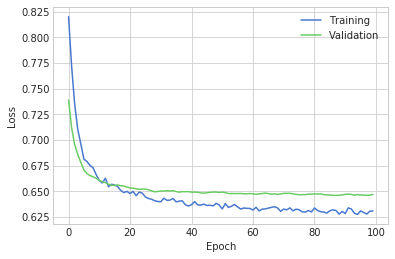

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Neural Network with raw data

In [17]:
def get_flat_data(raw):
    """Helper function for flattening the dataset.
    Extracts nested values in a dictionary
    and saves them as columns.
    """
    # Make a copy fo data
    data = raw.copy(deep=True)
    # Flatten the structure
    for fighter in ['fighter', 'opponent']:
        for a in data.iloc[0][fighter].keys():
            if a in ['history', 'current', 'bonus', 'streak']:
                for b in data.iloc[0][fighter][a]:
                    if b not in ['rounds']:
                        key = '{} {} {}'.format(fighter, a, b)
                        data[key] = data[fighter].apply(lambda x: x[a][b])
            elif a in ['stats']:
                for b in data.iloc[0][fighter][a]:
                    for c in data.iloc[0][fighter][a][b].keys():
                        key = '{} {} {} {}'.format(fighter, a, b, c)
                        data[key] = data[fighter].apply(lambda x: x[a][b][c])
            elif a in ['name', 'stance']:
                continue
            else:
                key = '{} {}'.format(fighter, a)
                data[key] = data[fighter].apply(lambda x: x[a])

    # Drop unnecessary features
    data.drop(['fighter', 'opponent',
               'referee', 'event', 'link', 'location',
               'method'], axis=1, inplace=True)
    
    # Split the data
    train, test = train_test_split(data)

    ytrain = train['result']
    ytrain = ytrain.map({'Win': 1, 'Loss': 0})
    xtrain = train.drop(['result', 'set', 'date'], axis=1)
    xtrain.fillna(0, inplace=True)
    
    ytest = test['result']
    ytest = ytest.map({'Win': 1, 'Loss': 0})
    xtest = test.drop(['result', 'set', 'date'], axis=1)
    xtest.fillna(0, inplace=True)
    
    # Scale data
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = pd.DataFrame(scaler.transform(xtrain), columns=xtrain.columns)
    xtest = pd.DataFrame(scaler.transform(xtest), columns=xtest.columns)
    
    return xtrain, xtest, ytrain, ytest

In [18]:
# Get the data
xtrain_flat, xtest_flat, ytrain_flat, ytest_flat = get_flat_data(data)

In [19]:
# Train the model
input_dim = xtrain_flat.shape[1]
model_flat = Sequential()
model_flat.add(Dense(8, input_dim=input_dim, activation='relu'))
model_flat.add(Dropout(0.5))
model_flat.add(Dense(4, activation='relu'))
model_flat.add(Dense(1, activation='sigmoid'))
model_flat.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [20]:
# Training the network
batch_size = 512
verbosity = 0 # 1 to see the output at each epoch
hist_flat = model_flat.fit(xtrain_flat.values, ytrain_flat, epochs=50,
                           batch_size=batch_size, validation_split=0.2, verbose=verbosity)

In [21]:
scores_flat = model_flat.evaluate(xtest_flat.values, ytest_flat, batch_size=batch_size)
print('\nNeural Network testing {:.2f}%'.format(scores_flat[1]*100))

 512/2554 [=====>........................] - ETA: 0s
Neural Network testing 57.13%


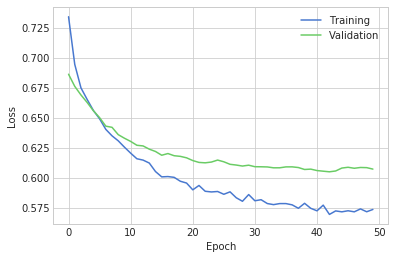

In [22]:
plt.plot(hist_flat.history['loss'])
plt.plot(hist_flat.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()